# CellRank

on donor P13 invading trophoblast

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import loompy
import scvelo as scv
import scanpy as sc
# requires 'pip install cellrank'
import cellrank as cr
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
#import palantir
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [2]:
np.random.seed(0)

In [3]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [4]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_analysis/'

In [5]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_root/build_artifac

In [6]:
colors_final = ['#d895ea', # EVT_1
               '#9f6bac', # EVT_2
               'purple', # EVT_3
               '#DBC7DE', # GC
               '#e7a3c8', # VCT_CCC
               'red', # eEVT
               'mediumvioletred', # iEVT
    
]


In [7]:
adata = sc.read(save_path+'adata_invading_trophoblast_with_trajectories_20201216.h5ad')

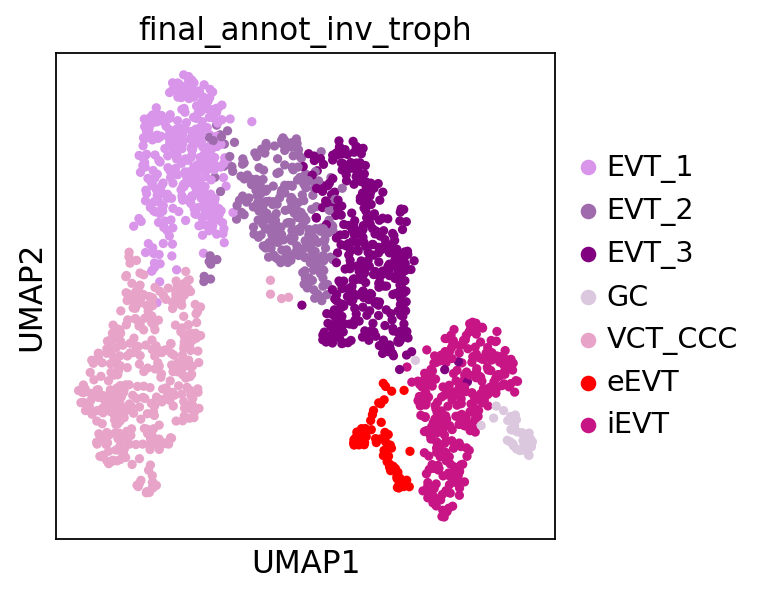

In [8]:
sc.pl.umap(adata, color='final_annot_inv_troph', palette=colors_final)

In [9]:
# loading also the object with the RNA velocity, all 4 samples, takes a few minutes
adata_rna_velocity = scv.read(save_path + '20210317_velocyto_donor_P13.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# dict of bam names to sample names
bam2sample = {}

bam2sample['possorted_genome_bam_7ZNK7'] = 'WSSS_PLA8764121'
bam2sample['possorted_genome_bam_V4O8B'] = 'WSSS_PLA8764122'
bam2sample['possorted_genome_bam_PSPJC'] = 'WSSS_PLA8810750'
bam2sample['possorted_genome_bam_T8XDM'] = 'WSSS_PLA8810751'



In [11]:
for barcode_sample in list(adata.obs['barcode_sample']):
    if '-1' not in barcode_sample:
        print(barcode_sample)

In [12]:
adata_rna_velocity

AnnData object with n_obs × n_vars = 323369 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [14]:
# getting from the indices above to the ones in adata.obs['barcode_sample']
adata_rna_velocity.obs['barcode_sample_sn_like'] = [elem.split(':')[1] + '-1_' + bam2sample[elem.split(':')[0]] for elem in adata_rna_velocity.obs_names]

In [15]:
adata_rna_velocity.obs.set_index('barcode_sample_sn_like', inplace=True)
adata_rna_velocity.obs

""
barcode_sample_sn_like
AAACCCAAGATCACCT-1_WSSS_PLA8764121
AAACCCAAGATCGCTT-1_WSSS_PLA8764121
AAACCCAAGATACATG-1_WSSS_PLA8764121
AAACCCAAGATTGCGG-1_WSSS_PLA8764121
AAACCCAAGACGCTCC-1_WSSS_PLA8764121
...
TTTGTTGTCGCTTGCT-1_WSSS_PLA8810751
TTTGTTGTCTGCGATA-1_WSSS_PLA8810751
TTTGTTGTCTGGCTGG-1_WSSS_PLA8810751


In [16]:
adata_rna_velocity.obs_names_make_unique()

In [17]:
adata_rna_velocity.obs_names

Index(['AAACCCAAGATCACCT-1_WSSS_PLA8764121',
       'AAACCCAAGATCGCTT-1_WSSS_PLA8764121',
       'AAACCCAAGATACATG-1_WSSS_PLA8764121',
       'AAACCCAAGATTGCGG-1_WSSS_PLA8764121',
       'AAACCCAAGACGCTCC-1_WSSS_PLA8764121',
       'AAACCCAAGAGTCAGC-1_WSSS_PLA8764121',
       'AAACCCAAGAGGATCC-1_WSSS_PLA8764121',
       'AAACCCAAGCTCACTA-1_WSSS_PLA8764121',
       'AAACCCAAGCGTGCTC-1_WSSS_PLA8764121',
       'AAACCCAAGCGGTAGT-1_WSSS_PLA8764121',
       ...
       'TTTGTTGTCCTCTCGA-1_WSSS_PLA8810751',
       'TTTGTTGTCGCAATTG-1_WSSS_PLA8810751',
       'TTTGTTGTCCTGGCTT-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTAGCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGTAGCCG-1_WSSS_PLA8810751',
       'TTTGTTGTCGCTTGCT-1_WSSS_PLA8810751',
       'TTTGTTGTCTGCGATA-1_WSSS_PLA8810751',
       'TTTGTTGTCTGGCTGG-1_WSSS_PLA8810751',
       'TTTGTTGTCTTAGTTC-1_WSSS_PLA8810751',
       'TTTGTTGTCTTCGGTC-1_WSSS_PLA8810751'],
      dtype='object', name='barcode_sample_sn_like', length=323369)

In [18]:
# subsetting to final cells only
adata_rna_velocity = adata_rna_velocity[[i for i in adata.obs['barcode_sample']]].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
adata_rna_velocity

AnnData object with n_obs × n_vars = 1729 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [20]:
adata_rna_velocity.var_names_make_unique()
adata_rna_velocity.obs_names_make_unique()

In [21]:
scv.pp.show_proportions(adata_rna_velocity)
#scv.pp.cleanup(adata_loom, clean='all')

Abundance of ['spliced', 'unspliced']: [0.19 0.81]


In [22]:
adata_rna_velocity

AnnData object with n_obs × n_vars = 1729 × 33538
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [23]:
adata_rna_velocity.layers['unspliced']

<1729x33538 sparse matrix of type '<class 'numpy.uint32'>'
	with 3397225 stored elements in Compressed Sparse Row format>

In [24]:
adata.obs

,n_genes,donor,tissue_block,age,sample,barcode_sample,percent_mito,n_counts,dataset,technique,...,louvain_R_2,prelim_annot_inv_troph,final_annot_inv_troph,root_score_+LGR5_+TP63,root_score_+LGR5_+TP63_-HLA-G_-MKI67,root_argmax_+LGR5_+TP63,root_argmax_+LGR5_+TP63_-HLA-G_-MKI67,rootcell,dpt_pseudotime,palantir_pseudotime
AACAACCAGTCCTGCG-1,2486,P13,PU8-9_B5,8-9_PCW,WSSS_PLA8764121,AACAACCAGTCCTGCG-1_WSSS_PLA8764121,0.000170,5877.0,snRNA-seq,10X,...,1,inv_troph_3,EVT_3,0.000000,-0.993825,0,0,0,0.736640,0.646171
AACACACCACTGAGGA-1,2081,P13,PU8-9_B5,8-9_PCW,WSSS_PLA8764121,AACACACCACTGAGGA-1_WSSS_PLA8764121,0.000291,3433.0,snRNA-seq,10X,...,0,VCT_CCC,VCT_CCC,0.000000,0.000000,0,0,0,0.229578,0.470050
AACCAACAGGTGGTTG-1,2721,P13,PU8-9_B5,8-9_PCW,WSSS_PLA8764121,AACCAACAGGTGGTTG-1_WSSS_PLA8764121,0.000157,6351.0,snRNA-seq,10X,...,"2,0",VCT_CCC,EVT_1,0.000000,-1.891354,0,0,0,0.258171,0.540808
AACCATGCACTAAACC-1,1718,P13,PU8-9_B5,8-9_PCW,WSSS_PLA8764121,AACCATGCACTAAACC-1_WSSS_PLA8764121,0.000244,4098.0,snRNA-seq,10X,...,0,VCT_CCC,VCT_CCC,2.894890,2.894890,0,0,0,0.227170,0.492076
AACCATGTCCAGCACG-1,1489,P13,PU8-9_B5,8-9_PCW,WSSS_PLA8764121,AACCATGTCCAGCACG-1_WSSS_PLA8764121,0.001342,2236.0,snRNA-seq,10X,...,0,VCT_CCC,VCT_CCC,1.699694,1.699694,0,0,0,0.219780,0.428034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGCATTGTAGC-1,3863,P13,PU8-9_B2,8-9_PCW,WSSS_PLA8810751,TTTACTGCATTGTAGC-1_WSSS_PLA8810751,0.000334,11983.0,snRNA-seq,10X,...,1,inv_troph_3,EVT_3,0.606780,-1.036591,0,0,0,0.720896,0.625391
TTTACTGTCTGCATGA-1,2917,P13,PU8-9_B2,8-9_PCW,WSSS_PLA8810751,TTTACTGTCTGCATGA-1_WSSS_PLA8810751,0.001026,6823.0,snRNA-seq,10X,...,4,inv_troph_4,EVT_2,0.000000,0.000000,0,0,0,0.550102,0.612573
TTTATGCCAGATACCT-1,2361,P13,PU8-9_B2,8-9_PCW,WSSS_PLA8810751,TTTATGCCAGATACCT-1_WSSS_PLA8810751,0.001711,5259.0,snRNA-seq,10X,...,4,inv_troph_4,EVT_2,0.000000,-1.569242,0,0,0,0.651858,0.690932
TTTGACTCAGGAATAT-1,3547,P13,PU8-9_B2,8-9_PCW,WSSS_PLA8810751,TTTGACTCAGGAATAT-1_WSSS_PLA8810751,0.000207,9681.0,snRNA-seq,10X,...,4,inv_troph_3,EVT_2,0.000000,-0.709489,0,0,0,0.634959,0.725957


In [25]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [26]:
# now let's also subset our velocity object to only filtered genes (about 27K)
# this didn't show great results, so now subsetting to HVGs previously calculated

In [27]:
# full version of adata - with all genes, only norm and log tr
#adata_full = anndata.AnnData(X = adata.raw.X,
#                             obs = adata.obs,
#                             var = adata.raw.var,
#                             obsm = adata.obsm,
#                             uns = adata.uns)


In [65]:
#adata_full.var_names_make_unique()

In [28]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

In [29]:
len(list(adata.var_names))

4790

In [30]:
len(set(adata.var_names))

4790

In [31]:
adata_rna_velocity = adata_rna_velocity[:,list(adata.var_names)].copy()

In [32]:
adata_rna_velocity

AnnData object with n_obs × n_vars = 1729 × 4790
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [33]:
adata.raw.X

<1729x27605 sparse matrix of type '<class 'numpy.float32'>'
	with 4574871 stored elements in Compressed Sparse Row format>

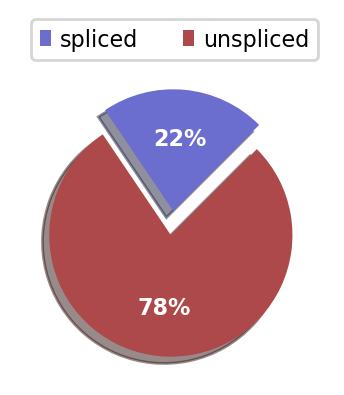

In [34]:
scv.pl.proportions(adata_rna_velocity)


In [35]:
adata_rna_velocity.var

,Accession,Chromosome,End,Start,Strand
A2M,ENSG00000175899,12,9116229,9067664,-
AAAS,ENSG00000094914,12,53324864,53307456,-
AACS,ENSG00000081760,12,125143333,125065379,+
AADACL2-AS1,ENSG00000242908,3,151928175,151751443,-
AADAT,ENSG00000109576,4,170091699,170060222,-
...,...,...,...,...,...
ZSWIM6,ENSG00000130449,5,61546170,61332273,+
ZUP1,ENSG00000153975,6,116668794,116635618,-
ZWINT,ENSG00000122952,10,56361275,56357228,-
ZXDB,ENSG00000198455,X,57597545,57591652,+


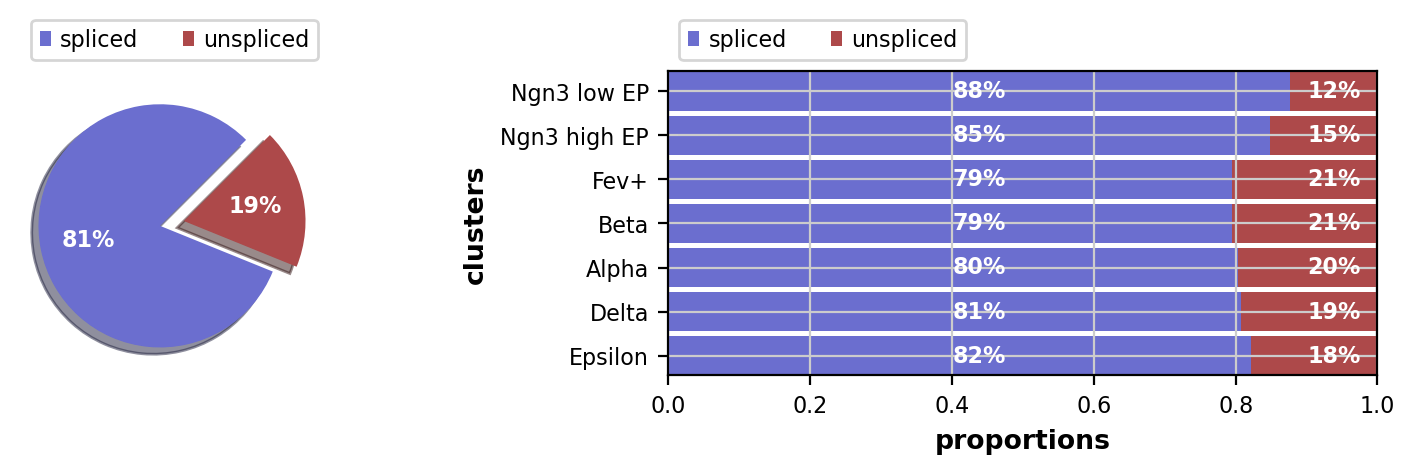

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [36]:
adata_test = cr.datasets.pancreas()
scv.pl.proportions(adata_test)
adata_test

In [37]:
# adding velocity stats into the full (all genes) object

for key in adata_rna_velocity.layers.keys():
    adata.layers[key] = adata_rna_velocity.layers[key]

In [38]:
adata

AnnData object with n_obs × n_vars = 1729 × 4790
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions'

# Preprocess the data

In [39]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
#sc.tl.pca(adata_full)
#sc.pp.neighbors(adata_full, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 3533 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Run scVelo

In [40]:
scv.tl.recover_dynamics(adata, n_jobs=8)


recovering dynamics (using 8/26 cores)


  0%|          | 0/378 [00:00<?, ?gene/s]

    finished (0:00:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/opt/conda/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/opt/conda/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [41]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


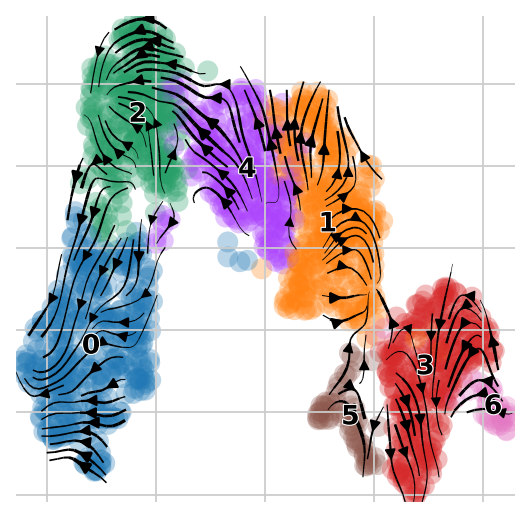

In [43]:
# only HVGs
scv.pl.velocity_embedding_stream(adata, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)


In [ ]:
# try to take only G1 cells?

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


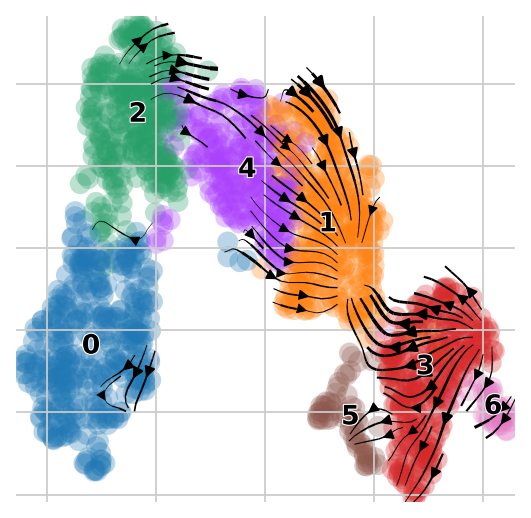

In [79]:
# all filtered genes
scv.pl.velocity_embedding_stream(adata_full, basis='umap', legend_fontsize=12, title='', smooth=.8, min_mass=4)


In [80]:
adata_full

AnnData object with n_obs × n_vars = 1729 × 2000
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime', 'initial_size', 'initial_size_spliced', 'initial_size_unspliced', 'velocity_self_transition'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene

In [44]:
adata

AnnData object with n_obs × n_vars = 1729 × 1257
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'barcode_sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_id', 'S_score', 'G2M_score', 'phase', 'celltype_predictions', 'barcode', 'souporcell_assignment', 'inter_ind_doublet', 'probabilities', 'louvain', 'is_doublet_propagate', 'origin_M_F', 'prelim_annot', 'louvain_R_2', 'prelim_annot_inv_troph', 'final_annot_inv_troph', 'root_score_+LGR5_+TP63', 'root_score_+LGR5_+TP63_-HLA-G_-MKI67', 'root_argmax_+LGR5_+TP63', 'root_argmax_+LGR5_+TP63_-HLA-G_-MKI67', 'rootcell', 'dpt_pseudotime', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'velocity_self_transition'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene

# Run CellRank

## Identify terminal states

In [45]:
cr.tl.terminal_states(adata, cluster_key='final_annot_inv_troph', 
                      n_states=2, weight_connectivities=0.2)


Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/1729 [00:00<?, ?cell/s]

Setting `softmax_scale=6.1418`


  0%|          | 0/1729 [00:00<?, ?cell/s]

    Finish (0:00:02)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:06)
Computing `2` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:12)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


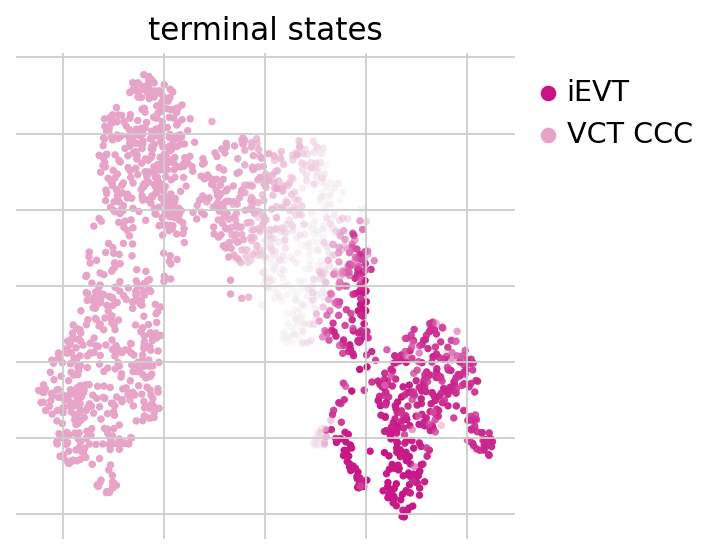

In [46]:
# only HVGs
cr.pl.terminal_states(adata)

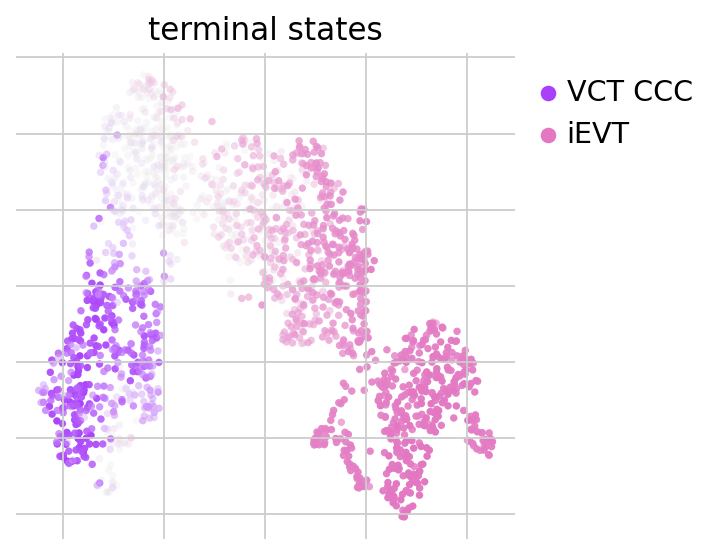

In [99]:
# all filtered genes
cr.pl.terminal_states(adata_full)

## Identify initial states

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/1729 [00:00<?, ?cell/s]

Setting `softmax_scale=6.1418`


  0%|          | 0/1729 [00:00<?, ?cell/s]

    Finish (0:00:01)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `.macrostates_memberships`
        `.macrostates`
    Finish (0:00:00)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `adata.obsm['macrostates_bwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


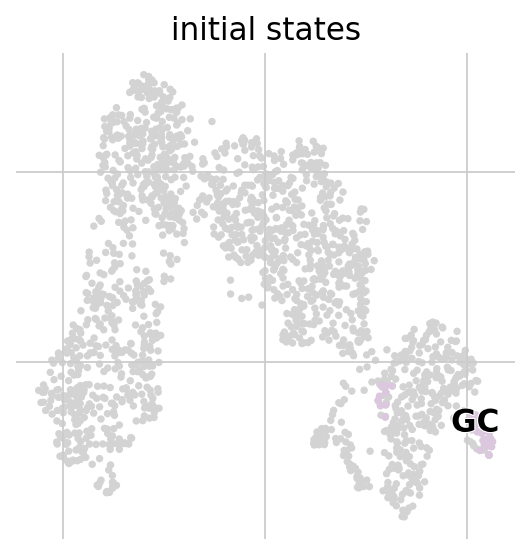

In [47]:
cr.tl.initial_states(adata, cluster_key='final_annot_inv_troph')
cr.pl.initial_states(adata, discrete=True)

## Compute fate maps

Computing lineage probabilities towards terminal states
Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/60 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:00)


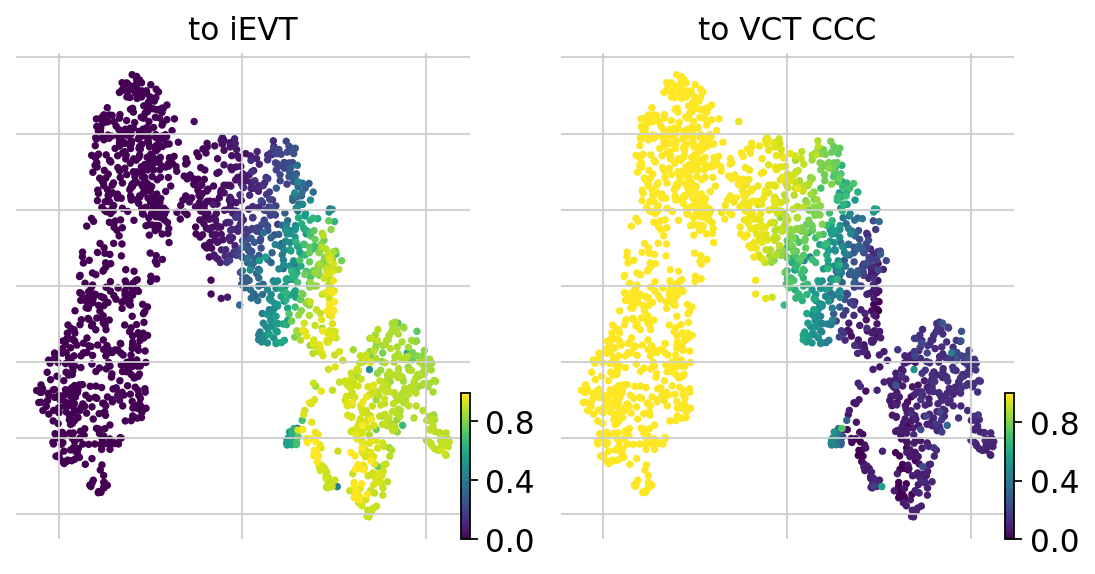

In [48]:
# all filtered genes
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

Computing lineage probabilities towards terminal states
Computing absorption probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/30 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:00)


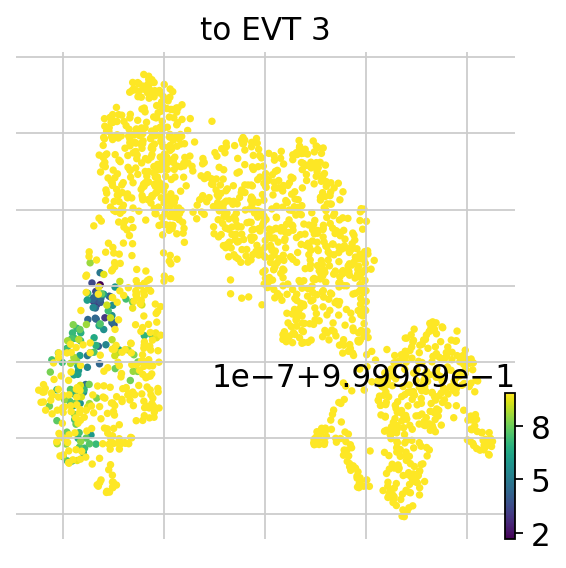

In [84]:
# all filtered genes
cr.tl.lineages(adata_full)
cr.pl.lineages(adata_full, same_plot=False)

# Directed PAGA

In [49]:
scv.tl.recover_latent_time(adata, root_key='initial_states_probs', end_key='terminal_states_probs')


computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [50]:
scv.tl.paga(adata, groups='final_annot_inv_troph', root_key='initial_states_probs', end_key='terminal_states_probs',
            use_time_prior='velocity_pseudotime')


running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plo

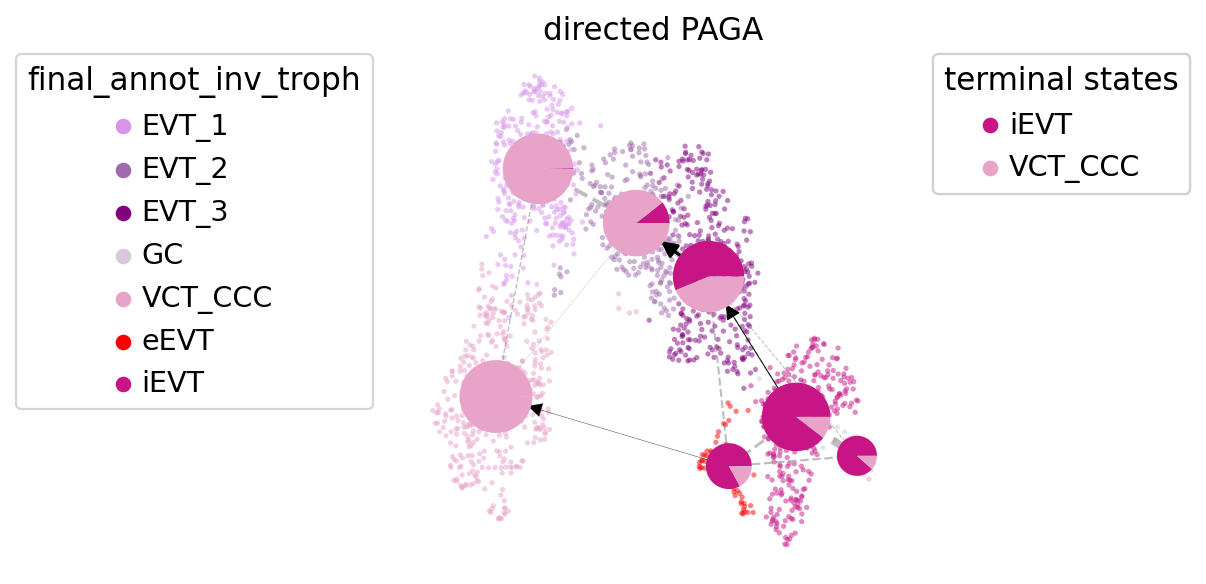

In [52]:
# only HVGs
cr.pl.cluster_fates(adata, mode="paga_pie", cluster_key="final_annot_inv_troph", basis='umap',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
                    node_size_scale=5, edge_width_scale=1, max_edge_width=4, title='directed PAGA')

/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plotting/paga.py:1090: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bboxes.append(result.inverse_transformed(ax.transData))
/opt/conda/lib/python3.8/site-packages/scvelo/plo

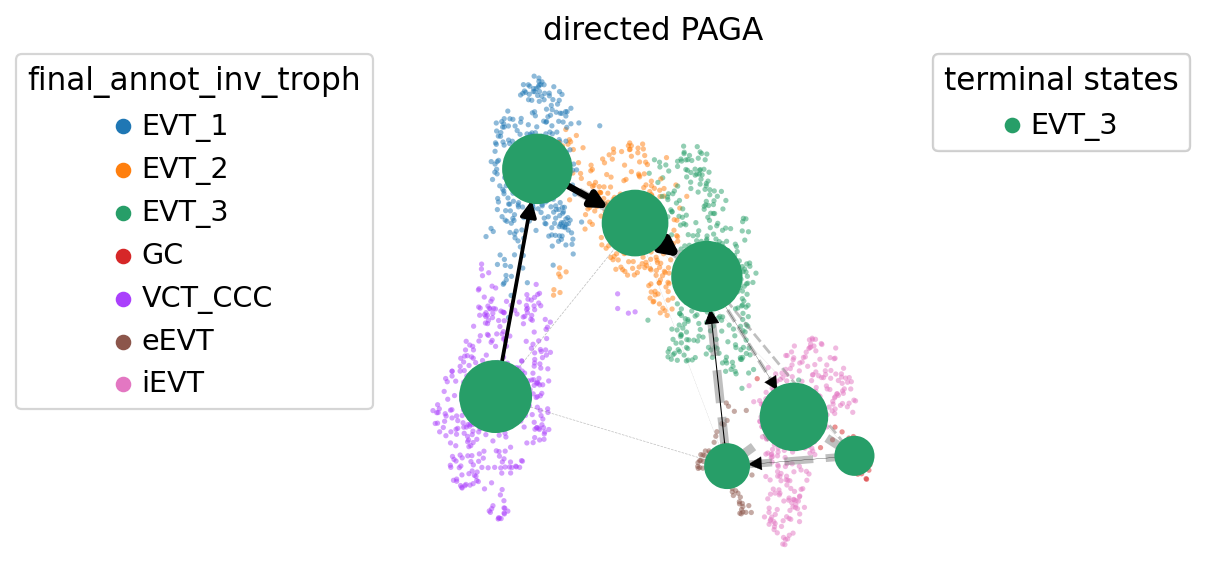

In [88]:
# all filtered genes
cr.pl.cluster_fates(adata_full, mode="paga_pie", cluster_key="final_annot_inv_troph", basis='umap',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
                    node_size_scale=5, edge_width_scale=1, max_edge_width=4, title='directed PAGA')